In [2]:
library('fpp3')
library('ggplot2')

### 1.0. Bank Calls

In [6]:
df = read.csv("../data/bank_calls.csv", header=TRUE, sep=",", stringsAsFactors=FALSE)

df = df |> select(DateTime, Calls)

df$DateTime = as.POSIXct(df$DateTime, format="%Y-%m-%d %H:%M:%S")

df = df |> as_tsibble(index=DateTime)

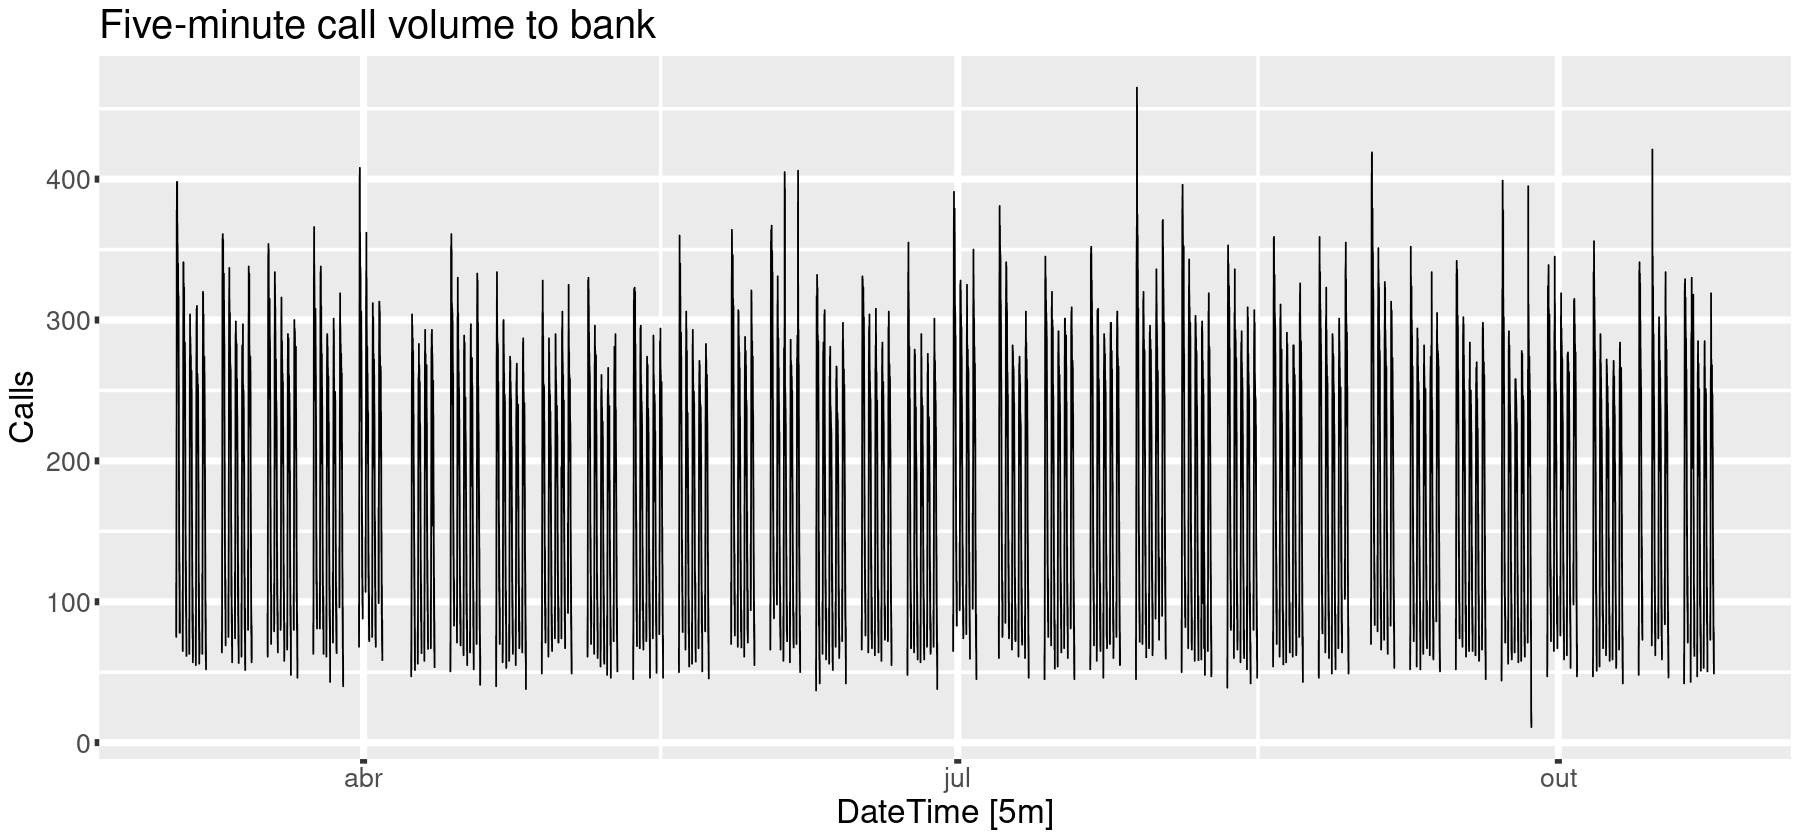

In [21]:
options(repr.plot.width=15, repr.plot.height=7)

df |> fill_gaps() |>
      autoplot(Calls) + labs(y="Calls", title="Five-minute call volume to bank") + 
                        theme(text=element_text(size=20), element_line(size=2))

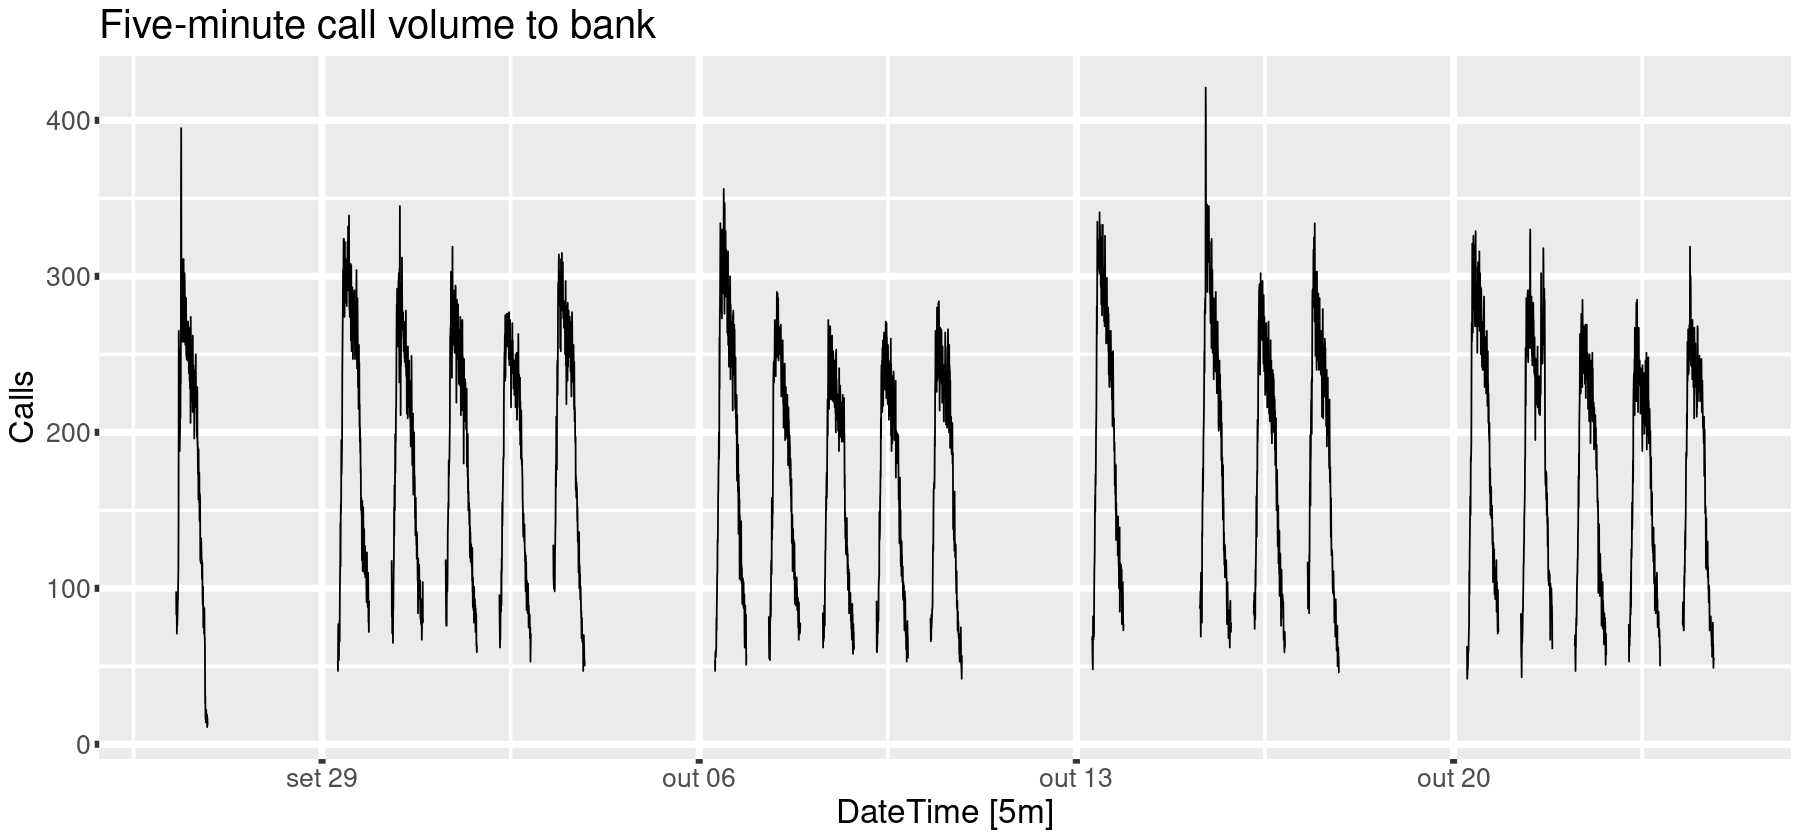

In [44]:
df |> tail(169 * 4 * 5) |> fill_gaps() |>
      autoplot(Calls) + labs(y="Calls", title="Five-minute call volume to bank") + 
                        theme(text=element_text(size=20), element_line(size=2))

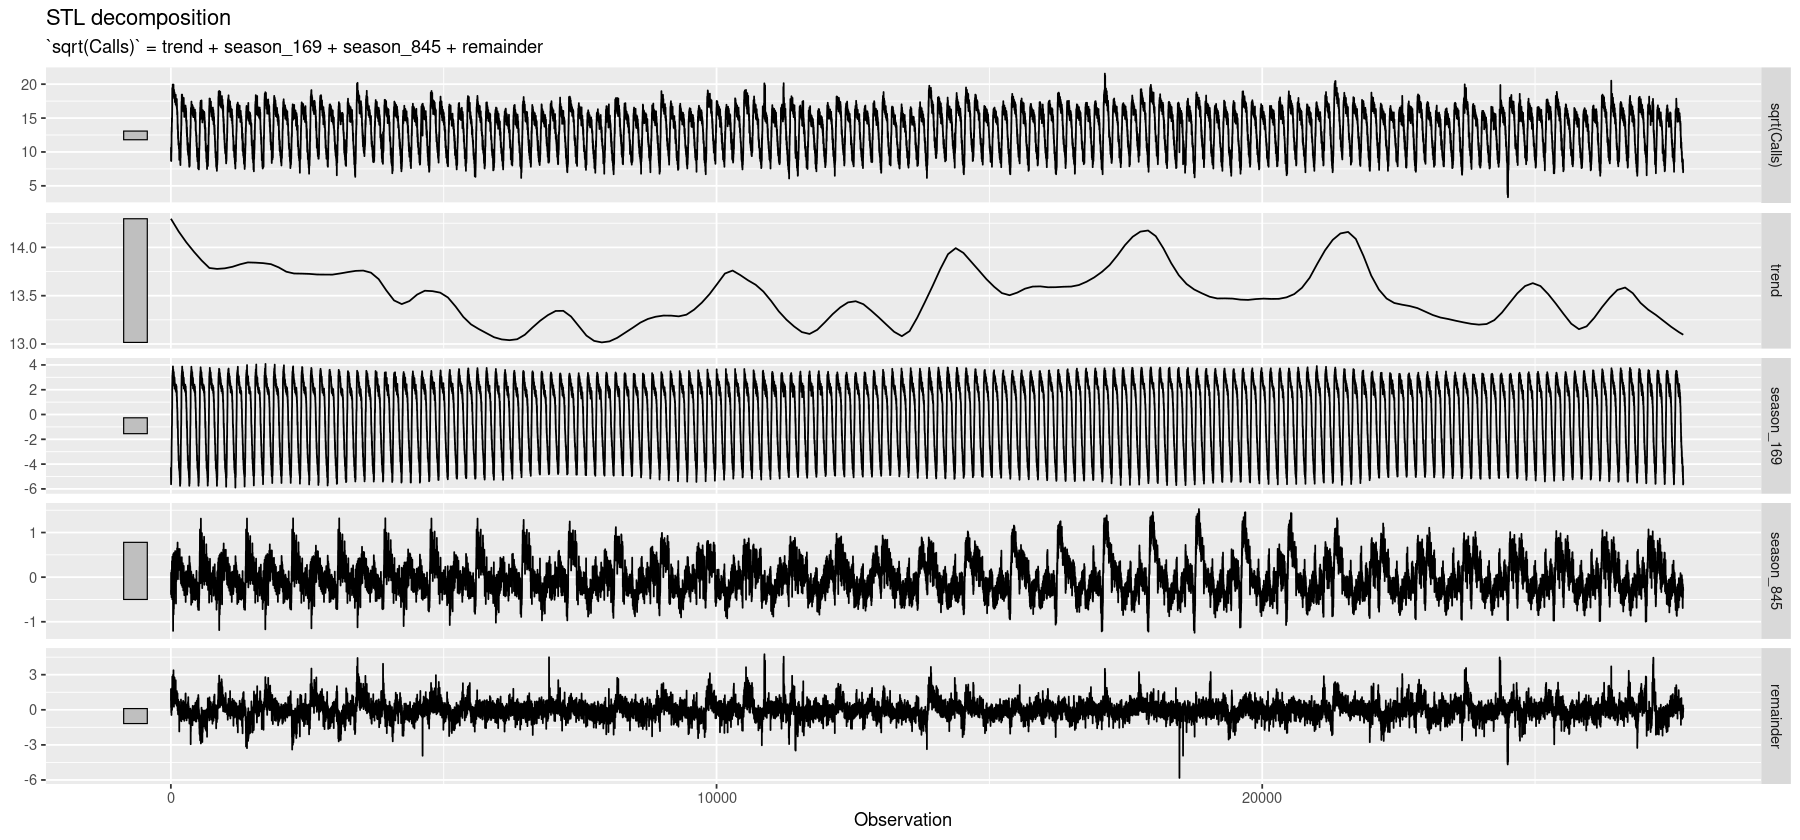

In [46]:
dfc = df |> mutate(t = row_number()) |> update_tsibble(index=t, regular=TRUE)

dfc |> model(STL(sqrt(Calls) ~ season(period=169) + season(period=5*169), robust=TRUE)) |> 
       components() |>
       autoplot() + labs(x="Observation")

In [57]:
my_d = decomposition_model(
    STL(sqrt(Calls) ~ season(period=169) + season(period=5 * 169), robust=TRUE),
    ETS(season_adjust ~ season("N"))
)

fc = dfc |> model(my_d) |> forecast(h=10 * 169)

In [65]:
head(fc)

tail(fc)

.model,t,Calls,.mean
<chr>,<dbl>,<dist>,<dbl>
my_d,27717,"t(N(8.8, 0.24))",76.81329
my_d,27718,"t(N(9.2, 0.25))",85.67062
my_d,27719,"t(N(8.9, 0.25))",79.83086
my_d,27720,"t(N(8.6, 0.26))",75.00363
my_d,27721,"t(N(9.2, 0.27))",84.99498
my_d,27722,"t(N(8.7, 0.28))",75.67703


.model,t,Calls,.mean
<chr>,<dbl>,<dist>,<dbl>
my_d,29401,"t(N(8, 13))",77.80918
my_d,29402,"t(N(7.7, 13))",72.25116
my_d,29403,"t(N(7.2, 13))",64.46761
my_d,29404,"t(N(7.4, 13))",67.82141
my_d,29405,"t(N(7.5, 13))",69.45189
my_d,29406,"t(N(7.1, 13))",64.01791


In [73]:
fc_with_times = df |> new_data(n = 7 * 24 * 60 / 5 * 2) |>
    mutate(time = format(DateTime, format="%H:%M:%S")) |> 
    filter(
        time %in% format(df$DateTime, format="%H:%M:%S"),
        wday(DateTime, week_start = 1) <= 5
    ) |>
    mutate(t = row_number() + max(dfc$t)) |>
    left_join(fc, by="t") |>
    as_fable(response="Calls", distribution=Calls)

In [74]:
head(fc_with_times)

DateTime,time,t,.model,Calls,.mean
<dttm>,<chr>,<dbl>,<chr>,<dist>,<dbl>
2003-10-27 07:00:00,07:00:00,27717,my_d,"t(N(8.8, 0.24))",76.81329
2003-10-27 07:05:00,07:05:00,27718,my_d,"t(N(9.2, 0.25))",85.67062
2003-10-27 07:10:00,07:10:00,27719,my_d,"t(N(8.9, 0.25))",79.83086
2003-10-27 07:15:00,07:15:00,27720,my_d,"t(N(8.6, 0.26))",75.00363
2003-10-27 07:20:00,07:20:00,27721,my_d,"t(N(9.2, 0.27))",84.99498
2003-10-27 07:25:00,07:25:00,27722,my_d,"t(N(8.7, 0.28))",75.67703


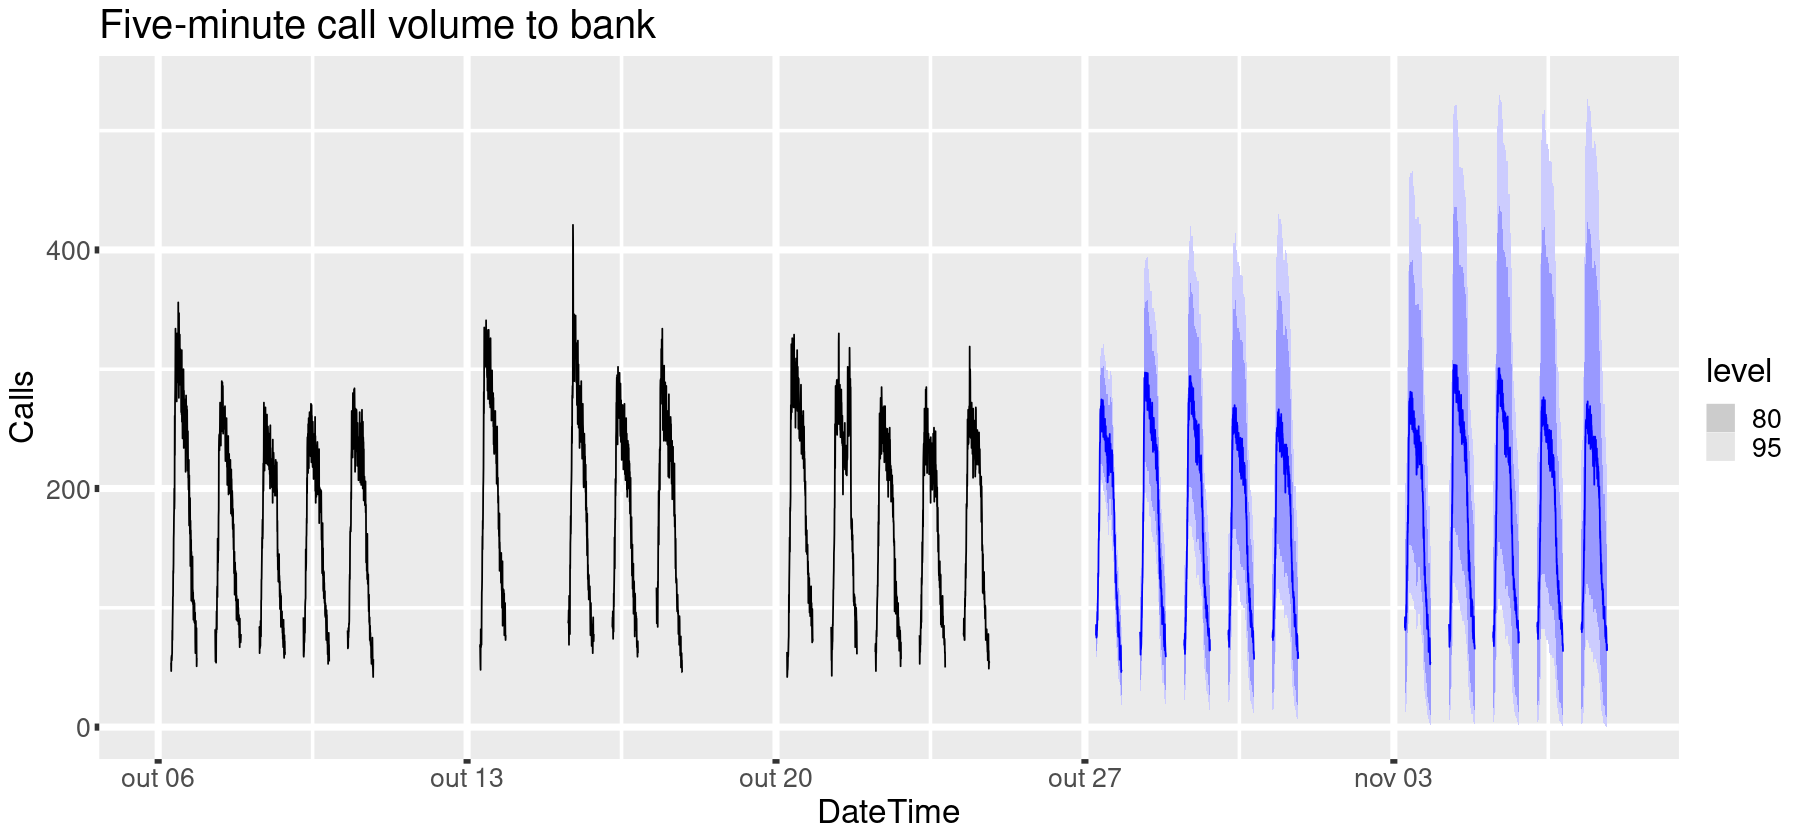

In [75]:
fc_with_times |> fill_gaps() |> autoplot(df |> tail(14 * 169) |> fill_gaps()) +
    labs(
        y = "Calls",
        title = "Five-minute call volume to bank"
    ) + theme(text=element_text(size=20), element_line(size=2))

In [76]:
head(dfc)

DateTime,Calls,t
<dttm>,<int>,<int>
2003-03-03 07:00:00,111,1
2003-03-03 07:05:00,113,2
2003-03-03 07:10:00,76,3
2003-03-03 07:15:00,82,4
2003-03-03 07:20:00,91,5
2003-03-03 07:25:00,87,6


In [77]:
fit = dfc |>
    model(
        dhr = ARIMA(
            sqrt(Calls) ~ PDQ(0, 0, 0) + pdq(d=0) +
            fourier(period=169, K=10) +
            fourier(period=5 * 169, K=5)
        )
    )

fc = fit |> forecast(h=10 * 169)

Warning message:
“Provided exogenous regressors are rank deficient, removing regressors: `fourier(period = 5 * 169, K = 5)C5_845`, `fourier(period = 5 * 169, K = 5)S5_845`”


In [78]:
fc_with_times = df |> new_data(n = 7 * 24 * 60 / 5 * 2) |>
    mutate(time = format(DateTime, format="%H:%M:%S")) |> 
    filter(
        time %in% format(df$DateTime, format="%H:%M:%S"),
        wday(DateTime, week_start = 1) <= 5
    ) |>
    mutate(t=row_number() + max(dfc$t)) |>
    left_join(fc, by="t") |>
    as_fable(response="Calls", distribution=Calls)

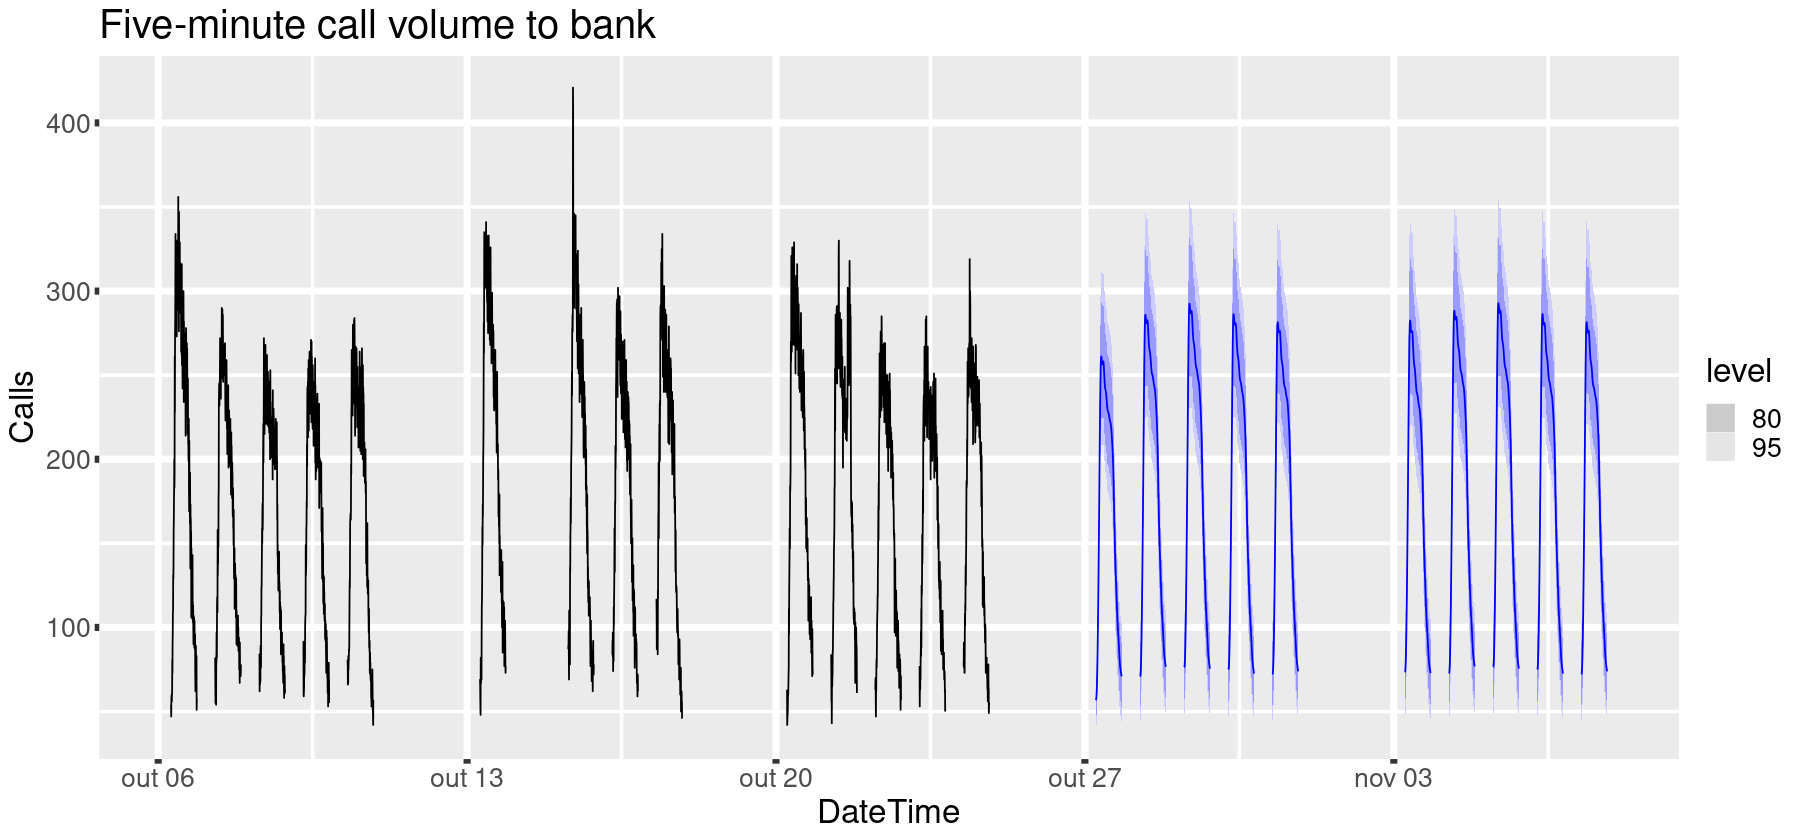

In [79]:
fc_with_times |> fill_gaps() |> autoplot(df |> tail(14 * 169) |> fill_gaps()) +
    labs(
        y = "Calls",
        title = "Five-minute call volume to bank"
    ) + theme(text=element_text(size=20), element_line(size=2))

In [89]:
head(fc_with_times)

DateTime,time,t,.model,Calls,.mean
<dttm>,<chr>,<dbl>,<chr>,<dist>,<dbl>
2003-10-27 07:00:00,07:00:00,27717,dhr,"t(N(7.5, 0.32))",56.67854
2003-10-27 07:05:00,07:05:00,27718,dhr,"t(N(7.5, 0.35))",57.09438
2003-10-27 07:10:00,07:10:00,27719,dhr,"t(N(7.6, 0.36))",57.73472
2003-10-27 07:15:00,07:15:00,27720,dhr,"t(N(7.6, 0.37))",58.68887
2003-10-27 07:20:00,07:20:00,27721,dhr,"t(N(7.7, 0.38))",60.13731
2003-10-27 07:25:00,07:25:00,27722,dhr,"t(N(7.9, 0.39))",62.14822
